In [1]:
# get data

In [1]:
import json
import os
import urllib
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    
    with open(file_path, "r") as file:
            data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
    )
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
# data

In [6]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="instruction-data.json")

In [8]:
dataset['train'][0]

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [7]:
def formatting_prompts_func(example):
    text = f"### Instruction: {example['instruction']}\n### Input: {example['input']}\n### Output: {example['output']}"
    return {"messages": text}

In [8]:
dataset['train']

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 1100
})

In [9]:
formatted_dataset = dataset.map(formatting_prompts_func)

In [11]:
formatted_dataset['train'][0]

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".',
 'messages': '### Instruction: Evaluate the following phrase by transforming it into the spelling given.\n### Input: freind --> friend\n### Output: The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [15]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import setup_chat_format

# Load model and tokenizer
model_id = "HuggingFaceTB/SmolLM2-360M"
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [26]:
# Do an initial visual assessement by asking some question

In [19]:


inputs = tokenizer.encode("Convert 45 kilometers to meters.", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Convert 45 kilometers to meters.

## How to convert 45 kilometers to meters?

To convert 45


In [20]:
def formatting_prompts_func(example):
    text = f"### Instruction: {example['instruction']}\n### Input: {example['input']}\n### Output: {example['output']}"
    return text

In [41]:
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer

# Configure trainer
training_args = SFTConfig(
    output_dir="./sft_smol_book2",
    # max_steps=1000,
    # per_device_train_batch_size=20,
    # learning_rate=5e-5,
    # logging_steps=10,
    # save_steps=100,
    # eval_strategy="steps",
    # eval_steps=50,
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset['train'],
    formatting_func=formatting_prompts_func,
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=414, training_loss=0.2515784738144437, metrics={'train_runtime': 116.9296, 'train_samples_per_second': 28.222, 'train_steps_per_second': 3.541, 'total_flos': 311013119577600.0, 'train_loss': 0.2515784738144437})

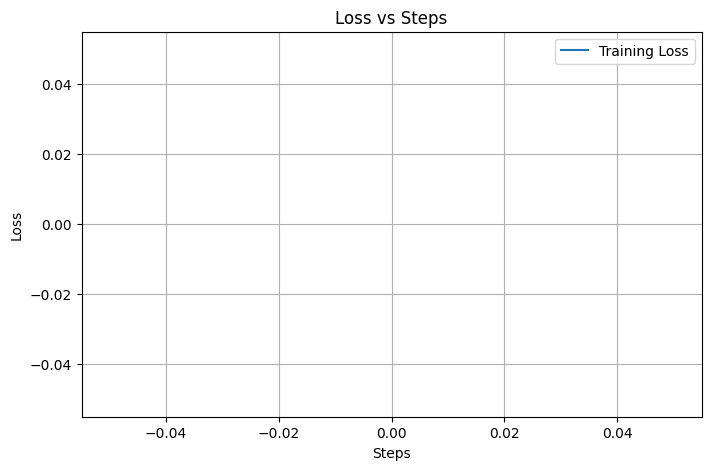

In [42]:
import matplotlib.pyplot as plt

# Extract loss and steps from trainer logs
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in trainer.state.log_history if "step" in log]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps[:-1], losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs Steps")
plt.legend()
plt.grid()
plt.show()


In [26]:
len(losses)

100

In [27]:
len(steps)

101

In [43]:
test_input = dataset['train'][0]
test_input

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [47]:
test_input = {
    'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': ''
 }

In [48]:
prompt = formatting_prompts_func(test_input)
prompt

'### Instruction: Rewrite the sentence using a simile.\n### Input: The car is very fast.\n### Output: '

In [49]:

# Ensure PAD token is set (important for causal models like LLaMA, Mistral, etc.)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS as PAD

inputs = tokenizer(prompt, return_tensors="pt",padding=True, truncation=True).to(device)
outputs = model.generate(**inputs,max_length=100)
print(tokenizer.decode(outputs[0],skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


### Instruction: Rewrite the sentence using a simile.
### Input: The car is very fast.
### Output:  The car is as fast as lightning.
### Explanation: The simile compares the speed of the car to that of lightning.

### Instruction: Rewrite the sentence using a metaphor.
### Input: The car is a speed demon.
### Output: The car is a beast.
### Explanation: The metaphor compares the speed of the car to
